In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

In [2]:
dfs3 = pd.read_csv('Data/Solar Data/Solar 3.csv')

In [3]:
dfs3

,Unnamed: 0,series_value,datetime,Year,Month,Day_of_Month,Hour,minutes,series_name
0,0,0.00,2019-06-05 14:00:00,2019,6,5,14,0,Solar3
1,4,0.00,2019-06-05 15:00:00,2019,6,5,15,0,Solar3
2,8,0.00,2019-06-05 16:00:00,2019,6,5,16,0,Solar3
3,12,0.00,2019-06-05 17:00:00,2019,6,5,17,0,Solar3
4,16,0.00,2019-06-05 18:00:00,2019,6,5,18,0,Solar3
...,...,...,...,...,...,...,...,...,...
12341,49364,0.00,2020-10-31 19:00:00,2020,10,31,19,0,Solar3
12342,49368,0.35,2020-10-31 20:00:00,2020,10,31,20,0,Solar3
12343,49372,1.11,2020-10-31 21:00:00,2020,10,31,21,0,Solar3
12344,49376,2.09,2020-10-31 22:00:00,2020,10,31,22,0,Solar3


In [6]:
data = dfs3['series_value'][4000:5000]

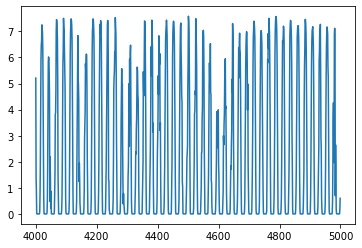

In [7]:
plt.plot(data)

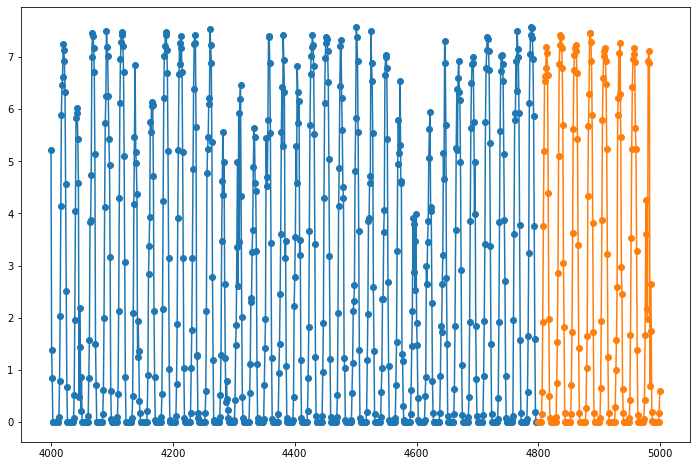

In [8]:
train_size = 0.8

ts = data

split_idx = round(len(data)* train_size)

# Split
train = ts.iloc[:split_idx]
test = ts.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(train, label='Train', **kws)
plt.plot(test, label='Test', **kws)

In [9]:
modelactual = auto_arima(train, start_p=0, start_q=0, seasonal=True)
modelactual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  800
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -931.172
Date:                Wed, 28 Sep 2022   AIC                           1872.345
Time:                        18:16:27   BIC                           1895.768
Sample:                             0   HQIC                          1881.343
                                - 800                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1643      0.013     12.811      0.000       0.139       0.189
ar.L1          1.8723      0.013    140.098      0.000       1.846       1.898
ar.L2         -0.9461      0.012    -81.585      0.000      -0.969      -0.923
ma.L1         -0.8208      0.027    -30.096      0.000      -0.874      -0.767
sigma2         0.5978      0.022     26.855      0.000       0.554       0.641
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):               255.22
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.11
Prob(H) (two-sided):                  0.38   Kurtosis:                         5.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [11]:
data = train
# define model
my_order = (2, 1, 1)
my_seasonal_order = (2, 1, 1, 24)
model = SARIMAX(data, order=my_order, seasonal_order=my_seasonal_order)
# fit model
model_fit = model.fit()
# one step forecast
yhat = model_fit.predict(end=len(test))

C:\Users\sohan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\sohan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [12]:
yhat

4000    0.000000e+00
4001    5.210000e+00
4002    1.380001e+00
4003    8.399995e-01
4004    1.000032e-02
            ...     
4196   -4.311929e-02
4197   -2.133473e-02
4198   -4.795801e-05
4199    4.491855e-06
4200   -1.577700e-07
Name: predicted_mean, Length: 201, dtype: float64

In [24]:
lst = []
for i in range(4007, 4201):
    lst.append(yhat[i])

In [25]:
forecastdf = pd.DataFrame(lst, columns=['forecast']) 

In [15]:
test

4800    0.00
4801    0.00
4802    0.00
4803    0.00
4804    0.00
        ... 
4995    0.00
4996    0.00
4997    0.00
4998    0.17
4999    0.60
Name: series_value, Length: 200, dtype: float64

In [27]:
lst = []
for i in range(4800, 4993):
    lst.append(test[i])

In [28]:
testdfnew = pd.DataFrame(lst, columns=['test']) 

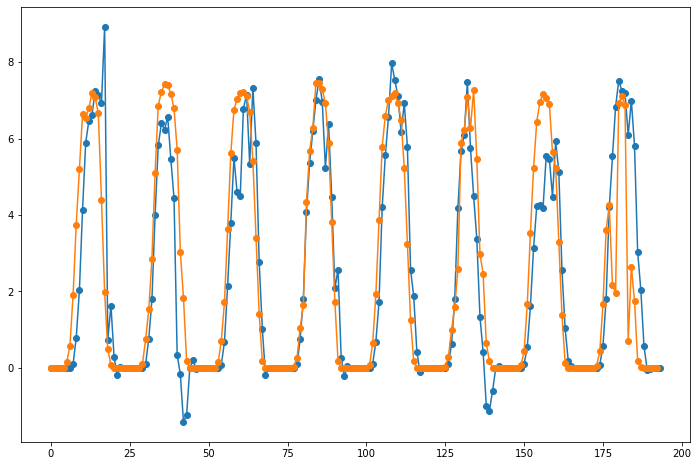

In [29]:
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(forecastdf['forecast'], label='Forecast', **kws)
plt.plot(testdfnew['test'], label='Test', **kws)

In [30]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))


pred = forecastdf['forecast'] 
tst = testdfnew['test']
trn = train

mean_absolute_scaled_error(pred,tst,trn)

1.3556690702600802